# Отток клиентов

**План исследования:**
1. подготовить данные для анализа
2. исследовать данные, понять закономерности, выявить основные признаки, влияющие на отток, оценить баланс классов
3. постройте модель с предельно большим значением *F1*-меры не менее 0,59.Обучить модели несбалансированных данных
4. масштабировать данные, исключить дисбаланс (при наличии)
5. провести тестирование моделей
6. измерить *AUC-ROC* и *F1*-меру на разных моделях обучения.
7. сделать выводы


## Подготовка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [ ]:
dt = pd.read_csv('/datasets/Churn.csv')

In [ ]:
#исследуем на предмет полноты данных
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
#переведем названия в строчные буквы
dt.columns = dt.columns.str.lower()
dt.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [ ]:
#считаем пустые значения
dt.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [ ]:
#посчитаем долю пропусков
print('В столбце tenure доля пустых строк {:.1%}'.format(dt['tenure'].isna().value_counts()[1]/len(dt)))

В столбце tenure доля пустых строк 9.1%


Учитывая, что строк с пустыми значениями по столбцу "tenure" 9% от выборки, то можно их удалить.

In [ ]:
dt = dt.dropna()
dt.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

Порядок обработки данных:  
    1. Исключаем несущественные признаки.  
    2. Кодируем OneHotEncoder категориальные признаки - пол и страна.  
    3. Рассчитываем значения tenure для заполнения пропусков с использованием классификатора дерева решений.      
    

In [ ]:
#исключаем данные, которые не существенны для анализа: уникальный идентификатор клиента, фамилия клиента, индекс строки в данных
dt=dt.drop(['customerid','surname','rownumber'],axis=1)

In [ ]:
#Разделяем обработанный датафрейм на обучающую и тестовую выборки, учла параметр stratify
target = dt['exited']
features = dt.drop('exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

Для кодирования данных в выборках с помощью OneHotEncoding из scikit-learn выполняем следующие шаги:

1. Импортируем класс OneHotEncoder из модуля sklearn.preprocessing.

2. Создаем объект OneHotEncoder с нужными параметрами, например, sparse=False, если хотим получить "плотный" массив вместо разреженной матрицы. Не забыть про drop='first' (возможно!).
    
3. Вызваем метод fit на объекте OneHotEncoder, передав ему обучающую выборку с категориальными признаками. Это позволит ему определить уникальные значения для каждого признака и создать соответствующие бинарные столбцы.
    
4. Вызваем метод transform на объекте OneHotEncoder, передав ему тестовую выборку с категориальными признаками. Это позволит ему преобразовать категориальные значения в бинарные столбцы, используя те же коды, что и для обучающей выборки.
    
5. Объединяем полученный массив с остальными числовыми признаками, например используя функцию numpy.concatenate или метод pandas.DataFrame.join.    
    
Почему нельзя кодировать сразу и тестовую и обучающую выборки? Потому что это может привести к утечке данных. Если мы кодируем сразу и тестовую и обучающую выборки, то таким образом в кодирование включается информация о категориях, которые не встречаются в обучающей выборке, но есть в тестовой. Это может дать модели преимущество при предсказании на тестовых данных, которое не отражает ее реальную способность обобщать на новых данных. Чтобы избежать этого, мы должны кодировать данные только на основе обучающей выборки и применять тот же энкодер к тестовой выборке.

In [ ]:
#Кодируем категориальные признаки - пол и страна
object_cols_cat = [col for col in features_train.columns if features_train[col].dtype == 'object']
ohe = OneHotEncoder(handle_unknown='ignore',sparse =False)
ohe_col_train = pd.DataFrame(ohe.fit_transform(features_train[object_cols_cat]))
ohe_col_valid = pd.DataFrame(ohe.transform(features_valid[object_cols_cat]))
ohe_col_train.index = features_train.index
ohe_col_valid.index = features_valid.index
X_train_cat = features_train.drop(object_cols_cat,axis =1)
X_valid_cat = features_valid.drop(object_cols_cat,axis =1)
ohe_X_train = pd.concat([X_train_cat,ohe_col_train],axis =1)
ohe_X_valid = pd.concat([X_valid_cat,ohe_col_valid],axis =1)
features_train = ohe_X_train
features_valid = ohe_X_valid

In [ ]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,0,1,2,3,4
9993,-0.073656,-1.036332,7.0,1.262714,1,1,0,-1.224135,1.0,0.0,0.0,0.0,1.0
0,-0.333215,0.298422,2.0,-1.226255,1,1,1,0.032686,1.0,0.0,0.0,1.0,0.0
7550,0.383169,-0.082936,7.0,0.756828,1,1,1,1.013408,1.0,0.0,0.0,1.0,0.0
454,1.109936,0.012403,6.0,0.818042,1,0,1,-0.747011,1.0,0.0,0.0,1.0,0.0
8564,-1.371454,0.870459,10.0,-0.085243,1,1,0,0.670247,1.0,0.0,0.0,0.0,1.0


In [ ]:
object_cols_cat

['geography', 'gender']

## Исследование задачи

Исследуем зависимость оттока от выбранных признаков на первоначальном датафрейме. Построим корреляционную матрицу.

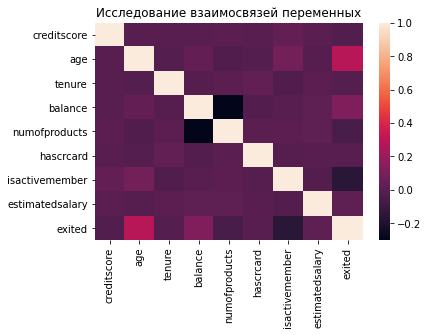

In [ ]:
sns.heatmap(dt.corr())
plt.title('Исследование взаимосвязей переменных')
plt.show()

Из корреляционной матрицы видно, что мультиколлинеарность между объясняющими переменными (факторами) регрессионной модели отсутсвует, значит выбранные переменные можно использовать для обучения моделей.

Ответим на вопрос: какая доля клиентов уходит из банка?

In [ ]:
dt.value_counts('exited', normalize=True)

exited
0    0.796062
1    0.203938
dtype: float64

Почти 20% клиентов перестают пользоваться услугами банка, а это пятая часть. Соотношение 1:4 - данные несбалансированы.  
Исследуем как различные признаки влияют на отток. Посмотрим на клиентов разных стран.

In [ ]:
dt.groupby(['geography'])['exited'].value_counts(normalize=True)

geography  exited
France     0         0.838901
           1         0.161099
Germany    0         0.672481
           1         0.327519
Spain      0         0.835409
           1         0.164591
Name: exited, dtype: float64

Самый большой отток в 32 процента клиентов в Германии. Рассморим какие признаки больше всего влияют на отток. Проверим влияние активности клиента.

In [ ]:
dt.groupby('isactivemember')['exited'].value_counts(normalize=True)

isactivemember  exited
0               0         0.731608
                1         0.268392
1               0         0.856625
                1         0.143375
Name: exited, dtype: float64

Неактивные клиенты в два раза чаще уходят из банка. Проверим зависит ли от пола клиента отток. Преобразуем категориальные признаки половой принадлежности в численные методом One-Hot Encoding. В закодированном виде Мужчина -0, женщина -1.

In [ ]:
dt = pd.get_dummies(dt, columns={'gender'}, drop_first=True)
dt.groupby('gender_Male')['exited'].value_counts(normalize=True)

gender_Male  exited
0            0         0.747146
             1         0.252854
1            0         0.836550
             1         0.163450
Name: exited, dtype: float64

Мужчины чаще меняют банки: 25 процентов мужчин уходят из банка против 16 процентов женщин. Разница в 10% может оказаться существенной.  
Исследуем влияние возраста на отток.

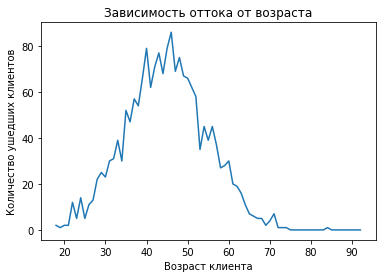

In [ ]:
dt.groupby('age')['exited'].sum().plot()
plt.title('Зависимость оттока от возраста')
plt.xlabel('Возраст клиента')
plt.ylabel('Количество ушедших клиентов')
plt.show()

Явно прослеживается то, что клиенты среднего возраста очень мобильны на предмет выбора банка. Клиенты в возрасте после 60 лет более постоянны в выборе банка. Думаю клиенты среднего возраста могут составлять большую часть клиентов банка. Проверим это. Проведем категоризацию данных по возрасту:
  менее 40 — 1
     41-60 — 2
61 и более — 3

In [ ]:
def categorize_age(age):
    try:
        if age <= 40:
            return '1'
        elif 41 <= age <= 60:
            return '2'
        elif 60 <= age:
            return '3'
    except:
        pass

In [ ]:
dt_categorize_age = dt.copy()
dt_categorize_age['categorize_age'] = dt['age'].apply(categorize_age)
dt_categorize_age.groupby('categorize_age')['exited'].sum().head()

categorize_age
1     622
2    1126
3     106
Name: exited, dtype: int64

Половина от всех клиентов - это люди в возрасте от 40 до 60 лет.

In [ ]:
dt_categorize_age.groupby('categorize_age')['exited'].value_counts(normalize=True)

categorize_age  exited
1               0         0.892980
                1         0.107020
2               0         0.604357
                1         0.395643
3               0         0.755196
                1         0.244804
Name: exited, dtype: float64

Почти 40 процентов из категории от 40 до 60 лет попадают в отток.  
Исследуем факт владения количеством продуктов банка клиентами.

In [ ]:
dt.groupby('numofproducts')['exited'].value_counts(normalize=True)

numofproducts  exited
1              0         0.722114
               1         0.277886
2              0         0.923040
               1         0.076960
3              1         0.824786
               0         0.175214
4              1         1.000000
Name: exited, dtype: float64

Преимущественно в оттток попадают клиенты, пользующие тремя или четыремя продуктами банка (очень странная ситуация).  
Преобразуем категориальные признаки в численные.

Преимущественно в оттток попадают клиенты, пользующие тремя или четыремя продуктами банка (очень странная ситуация).** - возможно это потребительский терроризм?

Чтобы выявить наиболее важные характеристики, влияющие на отток, построим модель, предсказывающую уход клиентов.

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(6818, 13)
(2273, 13)
(6818,)
(2273,)


Итак, к этому моменту мы знаем следующие факты о наших данных:

1. данные несбалансированны (записей с классом == 0 в 4 раза больше чем даных с классом == 1).

2. согласно ТЗ Заказчика нам требуется выполнить условие, что f1-мера должна быть больше 0.59

3. из теории в Тренажере мы знаем, что метрика **accuracy_score НЕ ПОКАЗАТЕЛЬНА** для оценки моделей (в задаче классификации) построенных на данных с дисбалансом классов.

Считаем полноту, точность и ф-меру. На основе сравнения результатов этих метрик принимай решение о качестве конкретной модели. Можно ещё матрицу ошибок (confusion matrix) построить.
</div>

Подбор лучших гиперпараметров модели будет искать методом RandomizedSearchCV

In [ ]:
#Модель №1 Классификация деревом решений, поиск лушших гиперпараметров
param1 = {
    'max_depth':[1,2,3,4,5,6,7,8],
    'max_leaf_nodes':[2,3,4,5,6,7,8,9,10]
}
model1 = DecisionTreeClassifier()
seach = RandomizedSearchCV(model1, param1, n_iter = 10, cv=5, random_state=12345)
#seach = GridSearchCV (model1,param1, cv=5)
seach.fit(features_train, target_train)
print('Лучшие параметры модели: ',seach.best_params_)

Лучшие параметры модели:  {'max_leaf_nodes': 8, 'max_depth': 6}


In [ ]:
#Тестирование модели с лучшими гиперпараметрами
best_seach1 = DecisionTreeClassifier(random_state=12345, max_leaf_nodes=8,max_depth=6)
best_seach1.fit(features_train, target_train)
predictions = best_seach1.predict(features_valid)

print('Матрица ошибок:\n', confusion_matrix(target_valid, predictions))
print('Полнота - Recall {:.0%}:'.format(recall_score(target_valid, predictions)))
print('Точность - Precision {:.0%}:'.format(precision_score(target_valid, predictions)))
print('F1 - мера: {:.2}'.format(f1_score(target_valid, predictions)))

Матрица ошибок:
 [[1728   81]
 [ 253  211]]
Полнота - Recall 45%:
Точность - Precision 72%:
F1 - мера: 0.56


In [ ]:
#Модель №2 Случайный лес, поиск лушших гиперпараметров
param2 = {
    'n_estimators' : [10,20,30,40,50,60],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'criterion' : ['entropy','gini']
}
model2 = RandomForestClassifier()
seach = RandomizedSearchCV(model2, param2, cv=5, random_state=12345)
#seach = GridSearchCV (model2, param2, cv=5)
seach.fit(features_train, target_train)
print('Лучшие параметры модели: ',seach.best_params_)

Лучшие параметры модели:  {'n_estimators': 50, 'max_depth': 8, 'criterion': 'entropy'}


In [ ]:
#Тестируем модель с лучшими гиперпараметрами
best_seach2 = RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=40,random_state=12345)
best_seach2.fit(features_train, target_train)
predictions = best_seach2.predict(features_valid)
print('Матрица ошибок:\n', confusion_matrix(target_valid, predictions))
print('Полнота - Recall {:.0%}:'.format(recall_score(target_valid, predictions)))
print('Точность - Precision {:.0%}:'.format(precision_score(target_valid, predictions)))
print('F1 - мера: {:.2}'.format(f1_score(target_valid, predictions)))

Матрица ошибок:
 [[1766   43]
 [ 264  200]]
Полнота - Recall 43%:
Точность - Precision 82%:
F1 - мера: 0.57


Обе модели не дотягивают до цели в достижении метрики F1-мера до 0.59

## Борьба с дисбалансом

Масштабируем численные признаки.

In [ ]:
pd.options.mode.chained_assignment = None
numeric = ['creditscore','age','balance','estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Масштабирование "обучается" на тренировочной выборке, а затем РЕЗУЛЬТАТ (обычно это scaler) последовательно применяется и к тренировочной и к тестовой выборкам.

Для чего нужно масштабировать признаки перед подачей в линейную модель машинного обучения (например в линейную регрессию)? Нам нужно минимизировать функцию потерь методом градиентного спуска. В случае разных масштабов признаков (например, год рождения и количество детей) её линии уровня будут иметь вид вытянутых эллипсов. Тогда вектор антиградиента и направление от текущей точки к минимуму функции потерь могут не совпадать, мы можем уйти далеко и не в ту сторону, и, в зависимости от шага градиентного спуска, либо придётся сделать больше итераций, либо вообще не будет сходимости. Если же признаки отмасштабированы, то линии уровня похожи на окружности. И проблема несовпадения антиградиента и направления к минимуму не так выражена.
</div>

In [ ]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,0,1,2,3,4
9993,-0.073656,-1.036332,7.0,1.262714,1,1,0,-1.224135,1.0,0.0,0.0,0.0,1.0
0,-0.333215,0.298422,2.0,-1.226255,1,1,1,0.032686,1.0,0.0,0.0,1.0,0.0
7550,0.383169,-0.082936,7.0,0.756828,1,1,1,1.013408,1.0,0.0,0.0,1.0,0.0
454,1.109936,0.012403,6.0,0.818042,1,0,1,-0.747011,1.0,0.0,0.0,1.0,0.0
8564,-1.371454,0.870459,10.0,-0.085243,1,1,0,0.670247,1.0,0.0,0.0,0.0,1.0


In [ ]:
features_valid.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,0,1,2,3,4
8337,-1.215718,0.203082,9.0,-1.226255,2,1,0,-1.490725,1.0,0.0,0.0,0.0,1.0
9169,1.192995,0.584441,6.0,-1.226255,2,0,0,0.830912,1.0,0.0,0.0,1.0,0.0
4836,-0.437039,-1.227011,10.0,0.802543,1,0,1,-0.972108,1.0,0.0,0.0,0.0,1.0
3751,-1.610249,-0.940992,2.0,-1.226255,2,1,0,-0.767690,0.0,0.0,1.0,0.0,1.0
4784,0.133992,1.347157,7.0,1.785062,1,1,0,1.513719,0.0,0.0,1.0,1.0,0.0


Анализ таргетных данных показал, что положительных результатов (количество покинувших банк клиентов "1") много меньше (всего 20%), чем оставшихся - 80%. Данные несбалансированные. Проведем балансировку техникой upsampling (увеличение выборки).
Предварительно разделим выборку на обучающую и тестовую. Для тестирования оставим выборку в объеме 25 процентов данных от представленного датасета.

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape )

(6818, 13)
(2273, 13)
(6818,)
(2273,)


**1 способ.** Увеличим выборку положительными ответами.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_train.shape)
print(target_train.shape)
print(features_upsampled.shape)
print(target_upsampled.shape)

(6818, 13)
(6818,)
(10988, 13)
(10988,)


**2 способ.** Уменьшим выборку за счет отрицательных ответов.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_train.shape)
print(target_train.shape)
print(features_downsampled.shape)
print(target_downsampled.shape)

(6818, 13)
(6818,)
(2747, 13)
(2747,)


**Вывод**  
Метод downsampled уменьшает выборку в три раза, а модель, обученная на малом объеме данных, с большой вероятностью будет переобучена. Поэтому для обучения выбираем выборку сбалансированную методом upsampled. Для выравнивания классов использовала соотношение 1 часть - "0" : 4 части - "1".

## Тестирование модели

Построим модели на сбалансированной выборке с подбором лучших гиперпараметров модели.

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(6818, 13)
(2273, 13)
(6818,)
(2273,)


In [ ]:
#Модель №1 Классификация деревом решений, поиск лушших гиперпараметров
param1 = {
    'max_depth':[1,2,3,4,5,6,7,8],
    'max_leaf_nodes':[2,3,4,5,6,7,8,9,10]
}
model1 = DecisionTreeClassifier()
seach = GridSearchCV (model1,param1, cv=5)
seach.fit(features_upsampled, target_upsampled)
print('Лучшие параметры модели: ', seach.best_params_)

Лучшие параметры модели:  {'max_depth': 5, 'max_leaf_nodes': 10}


In [ ]:
#Тестирование модели с лучшими гиперпараметрами
best_seach1 = DecisionTreeClassifier(random_state=12345, max_leaf_nodes=10,max_depth=5)
best_seach1.fit(features_upsampled, target_upsampled)
predictions = best_seach1.predict(features_valid)

print('Матрица ошибок:\n', confusion_matrix(target_valid, predictions))
print('Полнота - Recall {:.0%}:'.format(recall_score(target_valid, predictions)))
print('Точность - Precision {:.0%}:'.format(precision_score(target_valid, predictions)))
print('F1 - мера: {:.2}'.format(f1_score(target_valid, predictions)))

Матрица ошибок:
 [[1194  615]
 [  69  395]]
Полнота - Recall 85%:
Точность - Precision 39%:
F1 - мера: 0.54


**Вывод**  
**Precision**  - с точностью в **39%**   модель правильно предсказывает клиентов, которые уходят. Ошибки составляют 55%.  
**Recall - в 85%**, в 15% случаях модель относит клиентов к неушедшим, хотя на самом деле они уходят.  
**F1 - 0.54** - это усредненное значение между Precision & Recall, которое говорит, что наша модель на 60% справляется со своей задачей.  

F1 увеличилось с 0.52 до 0.54 на сбалансированных данных, но цель не достигнута.

In [ ]:
#Модель №2 Случайный лес, поиск лушших гиперпараметров
param2 = {
    'n_estimators' : [10,20,30,40,50,60],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'criterion' : ['entropy']
}
model2 = RandomForestClassifier()
seach = RandomizedSearchCV(model2, param2, cv=5, random_state=12345)
seach.fit(features_upsampled, target_upsampled)
print('Лучшие параметры модели: ', seach.best_params_)

Лучшие параметры модели:  {'n_estimators': 50, 'max_depth': 7, 'criterion': 'entropy'}


In [ ]:
#Тестируем модель с лучшими гиперпараметрами
best_seach2 = RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50,random_state=12345)
best_seach2.fit(features_upsampled, target_upsampled)
predictions = best_seach2.predict(features_valid)
print('Матрица ошибок:\n', confusion_matrix(target_valid, predictions))
print('Полнота - Recall {:.0%}:'.format(recall_score(target_valid, predictions)))
print('Точность - Precision {:.0%}:'.format(precision_score(target_valid, predictions)))
print('F1 - мера: {:.2}'.format(f1_score(target_valid, predictions)))

Матрица ошибок:
 [[1473  336]
 [ 124  340]]
Полнота - Recall 73%:
Точность - Precision 50%:
F1 - мера: 0.6


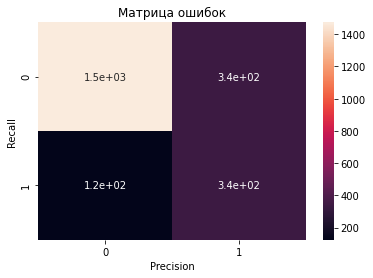

In [ ]:
sns.heatmap(confusion_matrix(target_valid, predictions),annot=True)
plt.title('Матрица ошибок')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

**Вывод**  
**Precision  - с точностью в 50%** показывает насколько правильно модель предсказывает клиентов, которые уходят. Ошибки составляют 50%.  
**Recall - в 73%**, свидетельствует, что в 27% случаях модель ложно срабатывает на 1 класс, то есть относит клиентов к неушедшим, хотя на самом деле они уходят.  
**F1 0.6** - это усредненное значение между Precision & Recall, которое говорит, что наша модель на 60% справляется со своей задачей.

**Вывод**  
Модель "Случайный лес" показала лучшую способность предсказать уход клиент из банка. Поэтому предлагается к использованию на реальных данных. Только в 28% случаях, если пользоваться предсказаниями модели, можно не предупредить уход клиентов из банка.

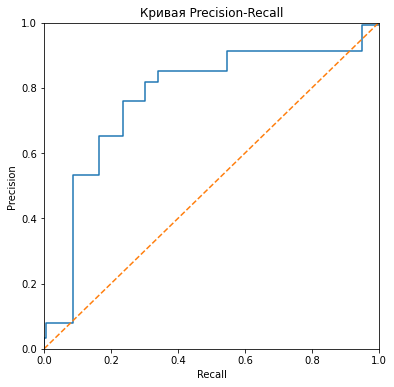

In [ ]:
probabilities_valid = best_seach1.predict_proba(features_valid)
probabilities_one_valid1 = probabilities_valid[:, 1]
recall, precision, thresholds = roc_curve(target_valid, probabilities_one_valid1)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Вычисляем площадь под кривой Precision-Recall

In [ ]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid1)
print('Площадь под кривой - метрика AUC_ROC: {:.0%}'.format(auc_roc))

Площадь под кривой - метрика AUC_ROC: 82%


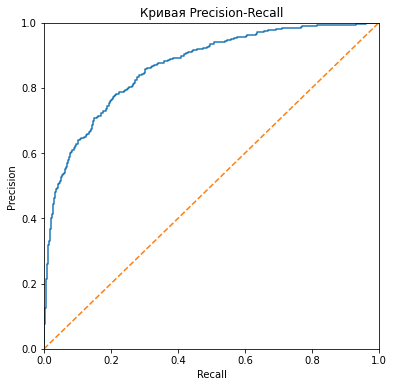

In [ ]:
probabilities_valid = best_seach2.predict_proba(features_valid)
probabilities_one_valid2 = probabilities_valid[:, 1]
recall, precision, thresholds = roc_curve(target_valid, probabilities_one_valid2)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Вычисляем площадь под кривой Precision-Recall

In [ ]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid2)
print('Площадь под кривой - метрика AUC_ROC: {:.0%}'.format(auc_roc))

Площадь под кривой - метрика AUC_ROC: 87%


Площадь под ROC-кривой (Area Under Curve – площадь под кривой, Receiver Operating Characteristic – рабочая характеристика приёмника ... пришло из области радиоэлектроники) – это метрика оценки для задач бинарной классификации. ROC-кривая показывает зависимость между долей верно классифицированных объектов положительного класса и долей ложноположительных объектов. Ну и сама площадь под ROC-кривой является мерой качества классификатора: чем выше значение AUC (Area Under Curve), тем лучше качество классификации конкретной модели. Наш глаз и мозг устроены так, что мы очень хорошо видим геометрическую разницу (в данном случае площадей).

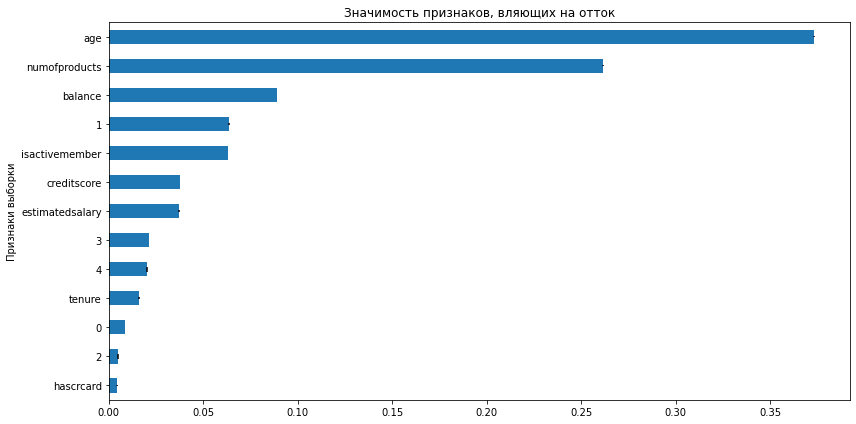

In [ ]:
feature_names = list(features_valid.columns.values)
importances = best_seach2.feature_importances_
dt_importances = pd.Series(importances, index=feature_names).sort_values()
std = np.std([tree.feature_importances_ for tree in best_seach2.estimators_], axis=0)
fig, ax = plt.subplots()
dt_importances.plot.barh(yerr=std, ax=ax, figsize=(12, 6))
ax.set_title("Значимость признаков, вляющих на отток")
ax.set_ylabel("Признаки выборки")
fig.tight_layout()

**Признаки, используемые в оценке влияния**  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
**Целевой признак**  
Exited — факт ухода клиента  

**Выводы**  
1. Самым значимым признаком, влияющим на отток клиентов в банке является возраст клиенов. Учитывая, что максимальную группу составляют клинты среднего возраста от 40 до 60 лет, а меньшее количество ушедших из банка клиентов пользуются двумя продуктами банка, необходимо активно предлагать клиенту в указанной возрастной кагорте второй продукт на выгодных условиях.  
2. Вторым по значимости для отток является количество продуктов банка, используемых клиентом. Как отмечалось выше, чтобы удержать клиентов в банке достаточно развивать парные предложения для клиентов, например на второй банковский делать льготные ставки, либо предлагать особые условия обслуживания счетов и другие доступные способы.
3. На третьем месте - баланс на счетах клиентов. Это обьяснимо тем, что если у клиента на счетах есть средства, значит он платежеспособен и он может активно пользоваться услугами банка для привлечения новых инвестиций, у него больше вероятность получить одобрение на пользование продуктами банка.
4. Не маловажную роль в оттоке клиентов играет активность клиента. Чем большая активность, тем меньше желание уйти из банка. Это говорит об удовлетворенности услугами и готовности далее продолжать сотруджничество.
